In [2]:
import os
import json

In [3]:

MODEL_MATHCODER_CL_7B = 'MathCoder-CL-7b'
MODEL_MATHCODER_CL_13B = 'MathCoder-CL-13b'
MODEL_MATHCODER_CL_34B = 'MathCoder-CL-34b'
MODEL_MATHCODER_L_7B = 'MathCoder-L-7b'
MODEL_MATHCODER_L_13B = 'MathCoder-L-13b'
MODEL_MATHCODER_L_70B = 'MathCoder-L-70b'

DATASET_GSM_8K = 'GSM8K'

In [4]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

data = {}

for model in [MODEL_MATHCODER_CL_7B, MODEL_MATHCODER_CL_13B, MODEL_MATHCODER_CL_34B, MODEL_MATHCODER_L_7B, MODEL_MATHCODER_L_13B, MODEL_MATHCODER_L_70B]:
    print(model)
    for file in os.listdir(os.path.join(model, DATASET_GSM_8K)):
        print("\t" + file)
        if file.endswith('.jsonl'):
            datum = load_jsonl(os.path.join(model, DATASET_GSM_8K, file))
            data[model + '-' + file[:-6]] = datum


MathCoder-CL-7b
	GSM8K_test_result.jsonl
	GSM8K_test_result-20230916-2152.jsonl
	GSM8K_test_result.json
MathCoder-CL-13b
	GSM8K_test_result-20230916-1444.jsonl
	GSM8K_test_result.jsonl
MathCoder-CL-34b
	GSM8K_test_result-20230916-1730.jsonl
	GSM8K_test_result-20230916-1443-wrong.jsonl
	GSM8K_test_result-20230916-1443-correct.jsonl
	GSM8K_test_result-20230917-1807.jsonl
	GSM8K_test_result.jsonl
	GSM8K_test_result-20230916-2019.jsonl
	GSM8K_test_result-20230916-1443.jsonl
	GSM8K_test_result-20230913-1304.jsonl
	GSM8K_test_result-20230917-0129.jsonl
	GSM8K_test_result-20230916-1730-wrong.jsonl
	GSM8K_test_result-20230916-1730-correct.jsonl
	GSM8K_test_result-20230913-1304-wrong.jsonl
	GSM8K_test_result-20230913-1304-correct.jsonl
	GSM8K_test_result-20230917-1807-wrong.jsonl
MathCoder-L-7b
	GSM8K_test_result-20230916-1751-correct.json
	GSM8K_test_result-20230916-1751-correct.jsonl
	GSM8K_test_result.jsonl
	GSM8K_test_result-20230916-1751-wrong.jsonl
	GSM8K_test_result-20230916-1751.jsonl
	

In [5]:
# for k in data.keys():
#     print(k)

llama_7b_keys = ['MathCoder-L-7b-GSM8K_test_result-20230916-1751-correct',
                 'MathCoder-L-7b-GSM8K_test_result-20230916-1751-wrong', 
                 'MathCoder-L-7b-GSM8K_test_result-20230916-1751']

data_llama_7b = {k: data[k] for k in llama_7b_keys}
data_llama_7b
# print(data.k/eys())

for k, v in data_llama_7b.items():
    print(k, len(v))
# data_llama_7b = data[MODEL_MATHCODER_L_7B + '-llama']


MathCoder-L-7b-GSM8K_test_result-20230916-1751-correct 849
MathCoder-L-7b-GSM8K_test_result-20230916-1751-wrong 470
MathCoder-L-7b-GSM8K_test_result-20230916-1751 1319


In [6]:
# Analyze some wrong answers from MathCoder-L-7b

data_llama_7b_correct = data_llama_7b['MathCoder-L-7b-GSM8K_test_result-20230916-1751-correct']
data_llama_7b_wrong = data_llama_7b['MathCoder-L-7b-GSM8K_test_result-20230916-1751-wrong']
print(len(data_llama_7b_wrong), len(data_llama_7b_correct))


#Metrics
    ## Number of times the ground truth was a decimal
    ## steps (lines) in ground truth
    ## types of operations in ground truth: +, -, *, /, % 
    ## cases where answer was right (eg; model outputs 0.666666 instead of 0.67)
    ## Number of times the output was an integer that was within 20% of the ground truth answer

470 849


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class MathDataset(Dataset):
    def __init__(self, data):
        self.data = []
        self.id_mapping = {}
        for i, d in enumerate(data):
            id = d['id']
            d_ = {}
            d_['id'] = id
            d_['ground_truth'] = d['ground_truth']
            try:
                d_['model_answer'] = d['model_answer']
            except KeyError:
                pass
            try:
                d_['completion'] = d['completion']
            except KeyError:
                pass
            try:
                d_['debug_result'] = d['debug_result']
            except KeyError:
                # print("Debugged Results do not exist for id: ", id)
                pass
            self.data.append(d_)
            self.id_mapping[id] = i 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, id):
        return self.data[int(id)]

    def get_by_id(self, id):
        return self.data[self.id_mapping[id]]
dataset_llama_7b_wrong = MathDataset(data_llama_7b_wrong)
dataset_llama_7b_correct = MathDataset(data_llama_7b_correct)

print(dataset_llama_7b_wrong.get_by_id('506')['model_answer'])

800


In [13]:
### Average number of steps in ground truth's solution

def average_steps(dataset):
    steps = 0
    for i, data in enumerate(dataset):
        # print(data['ground_truth']['solution'])
        steps += len(data['ground_truth']['solution'].split('\n'))
    return steps/len(dataset)

avg_steps_per_ground_truth_answer_correct = average_steps(dataset_llama_7b_correct)
avg_steps_per_ground_truth_answer_wrong = average_steps(dataset_llama_7b_wrong)

print(avg_steps_per_ground_truth_answer_correct, avg_steps_per_ground_truth_answer_wrong)

4.419316843345112 5.080851063829787


In [14]:
def operations_in_ground_truth(dataset, op):
    assert op in ['+', '-', '*', '/', '%'], "Invalid operation"
    cnt = 0
    for i, data in enumerate(dataset):
            if op in data['ground_truth']['solution']:
                cnt += 1
    return cnt

num_div_ops_correct = operations_in_ground_truth(dataset_llama_7b_correct, '/')
num_div_ops_wrong = operations_in_ground_truth(dataset_llama_7b_wrong, '/')
ratio_div_ops_correct = num_div_ops_correct/len(dataset_llama_7b_correct)
ratio_div_ops_wrong = num_div_ops_wrong/len(dataset_llama_7b_wrong)

num_mul_ops_correct = operations_in_ground_truth(dataset_llama_7b_correct, '*')
num_mul_ops_wrong = operations_in_ground_truth(dataset_llama_7b_wrong, '*')
ratio_mul_ops_correct = num_mul_ops_correct/len(dataset_llama_7b_correct)
ratio_mul_ops_wrong = num_mul_ops_wrong/len(dataset_llama_7b_wrong)

num_rem_ops_correct = operations_in_ground_truth(dataset_llama_7b_correct, '%')
num_rem_ops_wrong = operations_in_ground_truth(dataset_llama_7b_wrong, '%')
ratio_rem_ops_correct = num_rem_ops_correct/len(dataset_llama_7b_correct)
ratio_rem_ops_wrong = num_rem_ops_wrong/len(dataset_llama_7b_wrong)

print(ratio_div_ops_correct, ratio_div_ops_wrong)
print(ratio_mul_ops_correct, ratio_mul_ops_wrong)
print(ratio_rem_ops_correct, ratio_rem_ops_wrong)

0.5076560659599529 0.6042553191489362
0.7962308598351001 0.7829787234042553
0.0636042402826855 0.08297872340425531


In [15]:
def count_decimal_ground_truth(dataset, debug=False):
    cnt = 0
    for i, data in enumerate(dataset):
        ground_truth_answer = data['ground_truth']['answer']
        if '/' in ground_truth_answer or '\\' in ground_truth_answer:
            cnt += 1
            if debug:
                print(data['id'])
        elif '.' in ground_truth_answer:
            try:
                answer = float(ground_truth_answer)
                if answer.is_integer():
                    pass
                else:
                    cnt += 1
                    if debug:
                        print(data['id'])
            except ValueError:
                pass
    return cnt

def count_decimal_answer(dataset, debug=False):
    cnt = 0
    for i, data in enumerate(dataset):
        answer = data['completion']
        if '/' in answer or '\\' in answer:
            cnt += 1
            if debug:
                print(data['id'])
        elif '.' in answer:
            try:
                answer = float(answer)
                if answer.is_integer():
                    pass
                else:
                    cnt += 1
                    if debug:
                        print(data['id'])
            except ValueError:
                pass
    return cnt

num_decimal_ground_truth_correct = count_decimal_ground_truth(dataset_llama_7b_correct)
num_decimal_ground_truth_wrong = count_decimal_ground_truth(dataset_llama_7b_wrong)
ratio_decimal_ground_truth_correct = num_decimal_ground_truth_correct/len(dataset_llama_7b_correct)
ratio_decimal_ground_truth_wrong = num_decimal_ground_truth_wrong/len(dataset_llama_7b_wrong)

# print(dataset_llama_7b_wrong.get_by_id('506').keys())
num_decimal_answer_correct = count_decimal_answer(dataset_llama_7b_correct, debug=True)
num_decimal_answer_wrong = count_decimal_answer(dataset_llama_7b_wrong)
ratio_decimal_answer_correct = num_decimal_answer_correct/len(dataset_llama_7b_correct)
ratio_decimal_answer_wrong = num_decimal_answer_wrong/len(dataset_llama_7b_wrong)
num_integer_answer_wrong = len(dataset_llama_7b_wrong) - num_decimal_answer_wrong
ratio_integer_answer_wrong = num_integer_answer_wrong/len(dataset_llama_7b_wrong)


print(ratio_decimal_ground_truth_correct, ratio_decimal_ground_truth_wrong)
print(ratio_decimal_answer_correct, ratio_decimal_answer_wrong)
print(ratio_integer_answer_wrong)

gsm8k_train = MathDataset(load_jsonl('/home/raj/code/nlp/11711-s24-num-eval/MathCoder/data/GSM8K_train_post.jsonl'))

num_decimal_gsm8k_train = count_decimal_ground_truth(gsm8k_train)
print(num_decimal_gsm8k_train/len(gsm8k_train))

math_1_train = MathDataset(load_jsonl('/home/raj/code/nlp/11711-s24-num-eval/MathCoder/data/MATH_train_post.jsonl'))

num_decimal_math_1_train = count_decimal_ground_truth(math_1_train)
print(num_decimal_math_1_train/len(math_1_train))

0.0 0.0
0.0 0.1702127659574468
0.8297872340425532
0.0
0.26106666666666667


In [20]:
print(max([len(d['ground_truth']['solution'].split('\n')) for d in dataset_llama_7b_wrong]))
print(min([len(d['ground_truth']['solution'].split('\n')) for d in dataset_llama_7b_wrong]))

print(max([len(d['ground_truth']['solution'].split('\n')) for d in dataset_llama_7b_correct]))
print(min([len(d['ground_truth']['solution'].split('\n')) for d in dataset_llama_7b_correct]))

12
3
10
3


In [39]:
gt_lens_correct = [len(d['ground_truth']['solution'].split('\n')) for d in dataset_llama_7b_correct]
answer_lens_correct = [len(d['debug_result'])-2 for d in dataset_llama_7b_correct]

gt_lens_wrong = [len(d['ground_truth']['solution'].split('\n')) for d in dataset_llama_7b_wrong]
answer_lens_wrong = [len(d['debug_result'])-2 for d in dataset_llama_7b_wrong]

print(sum(gt_lens_correct)/len(gt_lens_correct), sum(gt_lens_wrong)/len(gt_lens_wrong))
print(sum(answer_lens_correct)/len(answer_lens_correct), sum(answer_lens_wrong)/len(answer_lens_wrong))

print(max(gt_lens_correct), min(gt_lens_correct))
print(max(gt_lens_wrong), min(gt_lens_wrong))
print(max(answer_lens_correct), min(answer_lens_correct))
print(max(answer_lens_wrong), min(answer_lens_wrong))

4.419316843345112 5.080851063829787
9.170789163722025 12.912765957446808
10 3
12 3
48 2
48 2


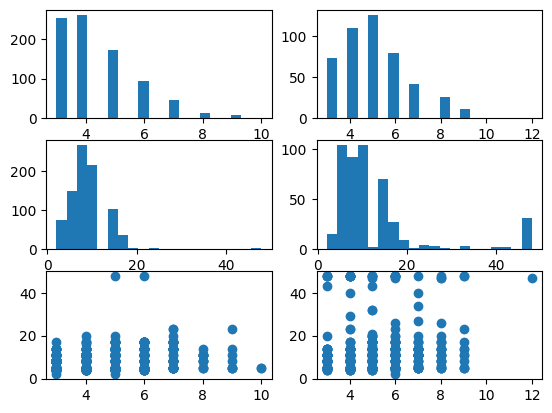

In [40]:
import matplotlib.pyplot as plt

plt.subplot(3, 2, 1)
#Put histohram in first subplot
plt.hist(gt_lens_correct, bins=20)
plt.subplot(3, 2, 2)
plt.hist(gt_lens_wrong, bins=20)

plt.subplot(3, 2, 3)
plt.hist(answer_lens_correct, bins=20)
plt.subplot(3, 2, 4)
plt.hist(answer_lens_wrong, bins=20)
# Put scatter plot in third row of subplots
plt.subplot(3, 2, 5)
plt.scatter(gt_lens_correct, answer_lens_correct)
plt.subplot(3, 2, 6)
plt.scatter(gt_lens_wrong, answer_lens_wrong)
plt.show()

In [46]:
def count_answer_off_by_percentage(dataset, percentage):
    cnt = 0
    for i, data in enumerate(dataset):
        try:
            answer = float(data['completion'])
            ground_truth = float(data['ground_truth']['answer'])
            if abs(answer - ground_truth)/ground_truth <= (percentage/100):
                cnt += 1
        except ValueError:
            pass
    return cnt

def count_answer_off_by_factor()


num_answer_off_by_50_correct = count_answer_off_by_percentage(dataset_llama_7b_correct, 50)
num_answer_off_by_50_wrong = count_answer_off_by_percentage(dataset_llama_7b_wrong, 50)

num_answer_off_by_30_correct = count_answer_off_by_percentage(dataset_llama_7b_correct, 30)
num_answer_off_by_30_wrong = count_answer_off_by_percentage(dataset_llama_7b_wrong, 30)

num_answer_off_by_20_correct = count_answer_off_by_percentage(dataset_llama_7b_correct, 20)
num_answer_off_by_20_wrong = count_answer_off_by_percentage(dataset_llama_7b_wrong, 20)

num_answer_off_by_10_correct = count_answer_off_by_percentage(dataset_llama_7b_correct, 10)
num_answer_off_by_10_wrong = count_answer_off_by_percentage(dataset_llama_7b_wrong, 10)

num_answer_off_by_5_correct = count_answer_off_by_percentage(dataset_llama_7b_correct, 5)
num_answer_off_by_5_wrong = count_answer_off_by_percentage(dataset_llama_7b_wrong, 5)

print(num_answer_off_by_50_correct/len(dataset_llama_7b_correct), num_answer_off_by_50_wrong/len(dataset_llama_7b_wrong))
print(num_answer_off_by_30_correct/len(dataset_llama_7b_correct), num_answer_off_by_30_wrong/len(dataset_llama_7b_wrong))
print(num_answer_off_by_20_correct/len(dataset_llama_7b_correct), num_answer_off_by_20_wrong/len(dataset_llama_7b_wrong))
print(num_answer_off_by_10_correct/len(dataset_llama_7b_correct), num_answer_off_by_10_wrong/len(dataset_llama_7b_wrong))
print(num_answer_off_by_5_correct/len(dataset_llama_7b_correct), num_answer_off_by_5_wrong/len(dataset_llama_7b_wrong))

0.967020023557126 0.3680851063829787
0.967020023557126 0.2127659574468085
0.967020023557126 0.14468085106382977
0.967020023557126 0.06170212765957447
0.967020023557126 0.029787234042553193
